<a href="https://colab.research.google.com/github/nouran551/hard-hat-detection/blob/master/hard__hat_detection_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Sep 13 09:37:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install object-detection-fastai

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import csv
import random
from google.colab import drive
 
 
import subprocess
 
from tqdm.notebook import tqdm
from xml.etree.ElementTree import parse
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as immg
from fastai.vision import *
from fastai import *
 
from pathlib import Path
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold,KFold
 
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
drive.mount('/content/gdrive')
path='/content/gdrive/My Drive/Hard hat detection challenge/_annotations.csv'
path_img='/content/gdrive/My Drive/Hard hat detection challenge/train'
path_all='/content/gdrive/My Drive/Hard hat detection challenge'
path_test = '/content/gdrive/My Drive/Hard hat detection challenge/test'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
annotation= pd.read_csv(path)
annotation.shape

(20231, 8)

In [8]:
annotation.head()

filename  width  ...  xmax ymax
0  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...    500  ...   330  135
1  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...    500  ...   370  158
2  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...    500  ...   223  137
3  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...    500  ...   295  132
4  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...    500  ...   174  141

[5 rows x 8 columns]

In [9]:
df = annotation.drop(['width','height'], axis = 1)
df.head()

filename class  ...  xmax  ymax
0  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...  head  ...   330   135
1  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...  head  ...   370   158
2  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...  head  ...   223   137
3  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...  head  ...   295   132
4  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...  head  ...   174   141

[5 rows x 6 columns]

In [10]:
df = df [['filename','xmin','ymin','xmax','ymax','class']]
df.head()

filename  xmin  ...  ymax  class
0  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...   301  ...   135   head
1  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...   340  ...   158   head
2  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...   199  ...   137   head
3  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...   277  ...   132   head
4  004858_jpg.rf.002ab521984d81c7400faa6f916f5a01...   154  ...   141   head

[5 rows x 6 columns]

In [11]:
arr = df["filename"].to_numpy()
print(arr)
arr.shape

['004858_jpg.rf.002ab521984d81c7400faa6f916f5a01.jpg' '004858_jpg.rf.002ab521984d81c7400faa6f916f5a01.jpg'
 '004858_jpg.rf.002ab521984d81c7400faa6f916f5a01.jpg' '004858_jpg.rf.002ab521984d81c7400faa6f916f5a01.jpg' ...
 '002219_jpg.rf.ff42125c486dacdf0b881197b5500215.jpg' '002219_jpg.rf.ff42125c486dacdf0b881197b5500215.jpg'
 '004208_jpg.rf.ff41745f0340f82a1b3d76d669e084a7.jpg' '004208_jpg.rf.ff41745f0340f82a1b3d76d669e084a7.jpg']


(20231,)

In [12]:
unique_arr = np.unique(arr)
print(unique_arr)
unique_arr.shape

['000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805.jpg' '000002_jpg.rf.85b55e30b8ce745e3c16966991a38018.jpg'
 '000003_jpg.rf.9fc4dfe06775f585757ede9300ba6af9.jpg' '000004_jpg.rf.6e499d6a5b40d901d318a92e672842ce.jpg' ...
 '005294_jpg.rf.5b6845af071b28aed341881f9ee64135.jpg' '005295_jpg.rf.3bdf25c46825aa098a0754b80992369a.jpg'
 '005296_jpg.rf.a9efe8ca20f1e8fd8052eb63e7a73859.jpg' '005297_jpg.rf.84c9d79a97d377470c9aae94b9cd2274.jpg']


(5269,)

In [13]:
file = unique_arr.tolist()
print(file)

['000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805.jpg', '000002_jpg.rf.85b55e30b8ce745e3c16966991a38018.jpg', '000003_jpg.rf.9fc4dfe06775f585757ede9300ba6af9.jpg', '000004_jpg.rf.6e499d6a5b40d901d318a92e672842ce.jpg', '000005_jpg.rf.2459a55dca0ff3afbe13f8d219a9a818.jpg', '000006_jpg.rf.6abcef9263250fa3bae58b72e8987b2b.jpg', '000007_jpg.rf.8e98fb789dfc011fb526ce49daf8da31.jpg', '000008_jpg.rf.e02009e902c74a6a08eee7ac6ef77bcb.jpg', '000009_jpg.rf.2b9c37488ee6a4dcc1193aaac99b9f55.jpg', '000010_jpg.rf.ff3d356d21409f8e9fe185536c4ecad9.jpg', '000011_jpg.rf.61884ddd74876b2c5be509879237cfe6.jpg', '000012_jpg.rf.2e49c7cac1f974388e32964f138453ca.jpg', '000013_jpg.rf.44ffce5c7121128de673c897043586c9.jpg', '000014_jpg.rf.48b4f5a271e853226260c311fa524ff5.jpg', '000015_jpg.rf.33fabf5a1aaea1c89da212e51ebc2e41.jpg', '000016_jpg.rf.80946bcc8f5f0a9f13c94fce3439dfad.jpg', '000017_jpg.rf.c6315f3e2f8de22636325c8eff927a44.jpg', '000018_jpg.rf.aa084e30d2b7507b19fc60cb45f9c62d.jpg', '000019_jpg.rf.60e6cb5bcf90

In [14]:
unique_arr.shape

(5269,)

In [15]:
labels_final = []
object_ymin_final=[]
object_xmax_final=[]
object_ymax_final=[]
object_xmin_final=[]


for i in tqdm(range(len(file))):
    labels = []
    object_xmin=[]
    object_ymin=[]
    object_xmax=[]
    object_ymax=[]

    for j in df.index:


        if df['filename'][j] == file[i] :
            object_xmin.append(df['xmin'][j])
            object_xmax.append(df['xmax'][j])
            object_ymin.append(df['ymin'][j])
            object_ymax.append(df['ymax'][j])
            labels.append(df['class'][j]) 
    
    object_xmin_final.append(object_xmin)
    object_xmax_final.append(object_xmax)
    object_ymin_final.append(object_ymin)
    object_ymax_final.append(object_ymax)
    labels_final.append(labels)
             

In [16]:
print(len(object_xmin_final))

5269


In [17]:
object_xmin_final

[[178, 111],
 [272, 141],
 [315, 175, 121, 242],
 [289, 320, 390, 268, 249, 374],
 [23, 252],
 [187, 154, 131, 9, 90],
 [280, 8, 115, 375, 412, 336, 247, 197, 174, 477],
 [295, 220, 189, 240, 313, 337, 152],
 [300],
 [439, 321, 211, 115],
 [207,
  43,
  14,
  25,
  81,
  100,
  112,
  144,
  193,
  184,
  238,
  254,
  268,
  346,
  298,
  339,
  363],
 [75, 284, 381, 242],
 [0],
 [437, 326, 228, 372, 326],
 [467, 321],
 [129],
 [150],
 [128],
 [254, 107, 181, 145, 303],
 [95, 149],
 [71],
 [257, 77, 197, 224, 167, 113, 158],
 [1,
  232,
  161,
  305,
  339,
  257,
  203,
  462,
  392,
  386,
  159,
  414,
  417,
  221,
  453,
  488],
 [81, 314, 193, 230, 361, 160, 201, 257, 284, 374],
 [64, 204, 340],
 [95, 167],
 [157, 214, 275, 376, 320],
 [257, 93, 133, 178, 224, 327],
 [24, 123],
 [58, 305, 280, 214, 172, 102, 124, 148, 38],
 [160, 276, 291],
 [227, 51],
 [33, 20],
 [194],
 [316, 393, 160],
 [48, 19, 69, 173],
 [47],
 [43, 244],
 [292],
 [139, 179, 146, 172, 145, 137],
 [46, 118, 

In [18]:
labels_final

[['helmet', 'helmet'],
 ['helmet', 'helmet'],
 ['helmet', 'helmet', 'helmet', 'helmet'],
 ['head', 'head', 'head', 'head', 'head', 'head'],
 ['helmet', 'helmet'],
 ['head', 'head', 'head', 'head', 'head'],
 ['helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet'],
 ['helmet', 'helmet', 'helmet', 'helmet', 'helmet', 'helmet', 'head'],
 ['helmet'],
 ['helmet', 'helmet', 'helmet', 'helmet'],
 ['helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'head',
  'helmet',
  'helmet',
  'helmet'],
 ['helmet', 'helmet', 'helmet', 'helmet'],
 ['helmet'],
 ['helmet', 'helmet', 'helmet', 'helmet', 'helmet'],
 ['helmet', 'helmet'],
 ['helmet'],
 ['helmet'],
 ['helmet'],
 ['head', 'head', 'head', 'head', 'head'],
 ['helmet', 'helmet'],
 ['helmet'],
 ['helmet', 'helmet', 'helmet', 'helmet', 'helmet', 'helmet', 'helmet'],
 ['helmet',
  'head'

In [19]:
print(len(labels_final))

5269


In [20]:
dframe = pd.DataFrame({'file_name':unique_arr,'xmin':object_xmin_final,'ymin':object_ymin_final,
                                   'xmax':object_xmax_final,'ymax':object_ymax_final,'labels':labels_final})

In [21]:
dframe

file_name  ...                                             labels
0     000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805...  ...                                   [helmet, helmet]
1     000002_jpg.rf.85b55e30b8ce745e3c16966991a38018...  ...                                   [helmet, helmet]
2     000003_jpg.rf.9fc4dfe06775f585757ede9300ba6af9...  ...                   [helmet, helmet, helmet, helmet]
3     000004_jpg.rf.6e499d6a5b40d901d318a92e672842ce...  ...               [head, head, head, head, head, head]
4     000005_jpg.rf.2459a55dca0ff3afbe13f8d219a9a818...  ...                                   [helmet, helmet]
...                                                 ...  ...                                                ...
5264  005293_jpg.rf.5367c5eb913cdfb77705f1c1c2553cd2...  ...  [helmet, helmet, helmet, helmet, helmet, helme...
5265  005294_jpg.rf.5b6845af071b28aed341881f9ee64135...  ...                           [helmet, helmet, helmet]
5266  005295_jpg.rf.3bdf25c46825aa098a0754b80992369a...  ...                                   [helmet, helmet]
5267  005296_jpg.rf.a9efe8ca20f1e8fd8052eb63e7a73859...  ...               [head, head, head, head, head, head]
5268  005297_jpg.rf.84c9d79a97d377470c9aae94b9cd2274...  ...                                           [helmet]

[5269 rows x 6 columns]

In [22]:
def image_lbl(dframe):
    hat2bbox = {}
    for i in tqdm(range(dframe.shape[0])):
        bbox = []
        lbl =[]
        title = []
        a = dframe.iloc[i][1:-1].values
        l = dframe.iloc[i][-1]
        for j in range(len(l)):
            bbx = [x[j] for x in a]
            if l[j]!='person':
                bbx = [bbx[1],bbx[0],bbx[3],bbx[2]]
                lbl.append(bbx)
                title.append(l[j])
        bbox.append(lbl)
        bbox.append(title)
        hat2bbox[dframe.iloc[i][0]] = bbox
    return hat2bbox

In [23]:
hat2bbox = image_lbl(dframe)

In [24]:
hat2bbox

{'000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805.jpg': [[[84, 178, 143, 230],
   [144, 111, 174, 134]],
  ['helmet', 'helmet']],
 '000002_jpg.rf.85b55e30b8ce745e3c16966991a38018.jpg': [[[53, 272, 111, 325],
   [83, 141, 131, 181]],
  ['helmet', 'helmet']],
 '000003_jpg.rf.9fc4dfe06775f585757ede9300ba6af9.jpg': [[[3, 315, 47, 372],
   [152, 175, 189, 204],
   [8, 121, 46, 157],
   [46, 242, 79, 269]],
  ['helmet', 'helmet', 'helmet', 'helmet']],
 '000004_jpg.rf.6e499d6a5b40d901d318a92e672842ce.jpg': [[[77, 289, 132, 326],
   [61, 320, 136, 375],
   [93, 390, 155, 440],
   [91, 268, 132, 298],
   [104, 249, 138, 275],
   [94, 374, 140, 407]],
  ['head', 'head', 'head', 'head', 'head', 'head']],
 '000005_jpg.rf.2459a55dca0ff3afbe13f8d219a9a818.jpg': [[[54, 23, 149, 111],
   [84, 252, 158, 317]],
  ['helmet', 'helmet']],
 '000006_jpg.rf.6abcef9263250fa3bae58b72e8987b2b.jpg': [[[84, 187, 135, 218],
   [82, 154, 141, 195],
   [100, 131, 140, 160],
   [68, 9, 141, 75],
   [105, 90, 134, 119]]

In [25]:
def show_sam(n):
    name = df.iloc[n][0] 
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(immg.imread(os.path.join(path_img,name)))
    B = hat2bbox[name]
    for l,bbox in zip(B[1],B[0]):
        bbox = [bbox[1],bbox[0],bbox[3],bbox[2]]
        bbox[2] = abs(bbox[0]-bbox[2])
        bbox[3] = abs(bbox[1]-bbox[3])
        draw_rect(ax,bbox,text=l)
    plt.axis('off')

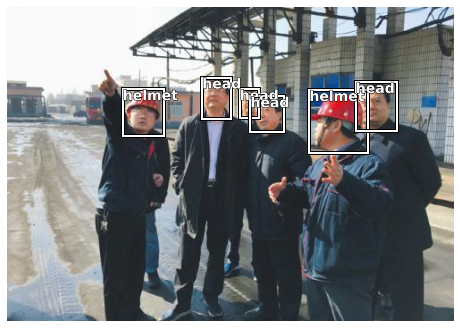

In [26]:
show_sam(random.randint(0,5268))   #randint(start, end)


create Data Batch

In [27]:
get_y_func = lambda o: hat2bbox[Path(o).name] 

In [28]:
tfms = 5
size = 512

In [29]:
data = (ObjectItemList.from_df(dframe ,path_all, folder = 'train' ,cols='file_name')
        #Where are the images? ->
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(size=size,tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=8, collate_fn=bb_pad_collate))  

/usr/local/lib/python3.6/dist-packages/fastai/vision/data.py:361: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  if len((labels - self.pad_idx).nonzero()) == 0: return


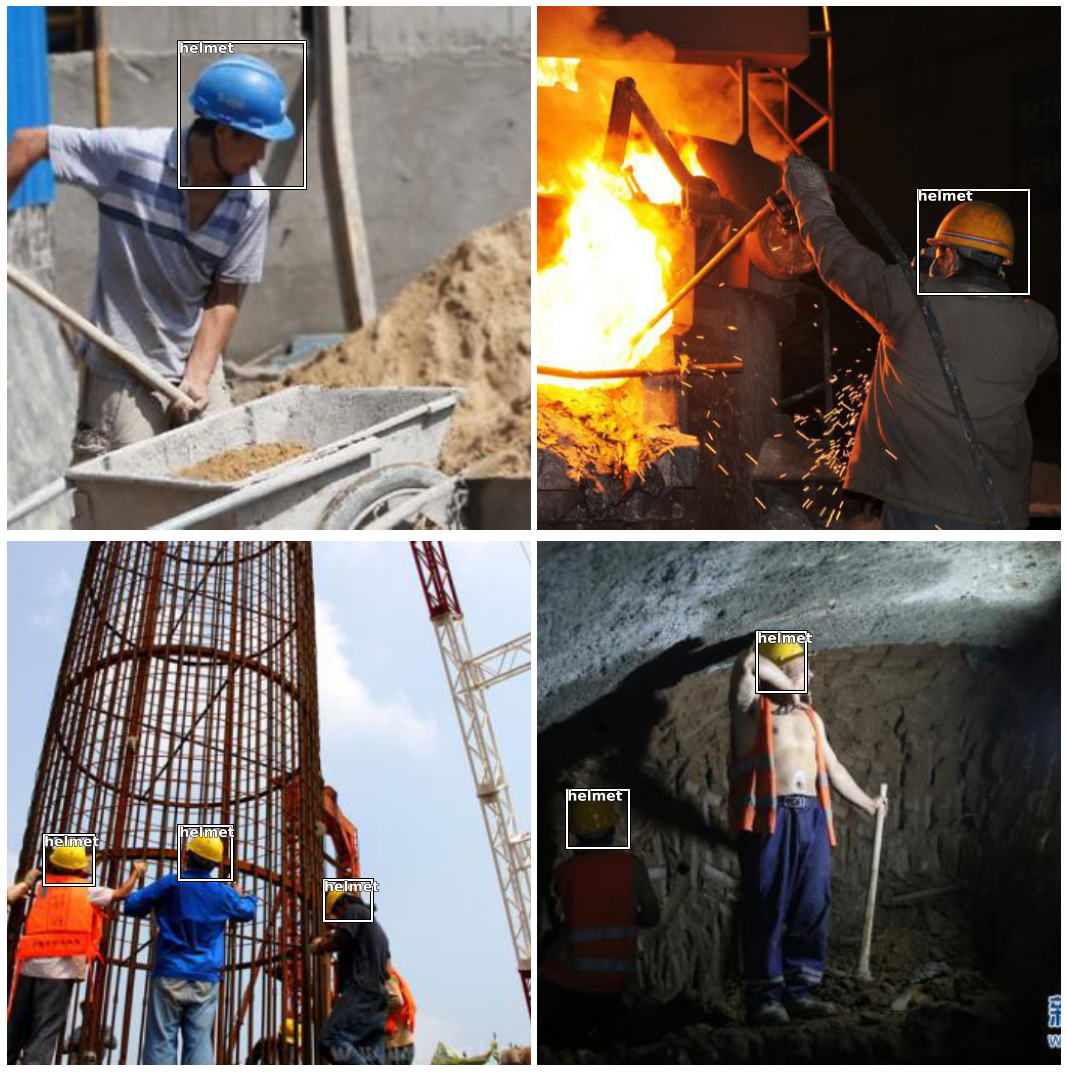

In [30]:
data.show_batch(rows=2,  figsize=(15,15))

In [31]:
len(data.train_ds),len(data.valid_ds),data.classes

(4216, 1053, ['background', 'head', 'helmet'])

In [32]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.3, 0.6, 1.2, 2, 2.8, 3.4,])

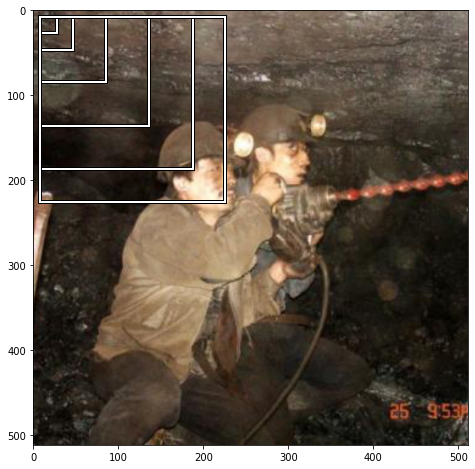

In [33]:
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:6]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [34]:
len(anchors)


6144

Now create the network. Note that for this step, internet access is required, since fast.ai wants to download the pre-trained weights for the ResNet18 stem.

In [35]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=6, sizes=[32], chs=32, final_bias=-4., n_conv=3)
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, 
                loss_func=crit, 
                callback_fns=[BBMetrics],
                metrics=[voc],
                model_dir='/content/gdrive/My Drive/Hard hat detection challenge')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [36]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [37]:
gc.collect()

12414

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


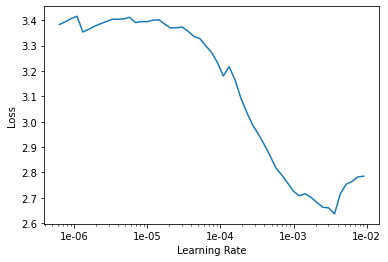

In [38]:
learn.lr_find()
learn.recorder.plot()


the loss was very good starting from 1e-03

In [39]:
learn.fit_one_cycle(3, 1e-3 , callbacks = [ SaveModelCallback(learn, every ='improvement', monitor = 'AP-helmet', name = 'best_model' ) ] )

Better model found at epoch 0 with AP-helmet value: 0.4584388191469073.
Better model found at epoch 1 with AP-helmet value: 0.7141415345246648.
Better model found at epoch 2 with AP-helmet value: 0.7290581104574834.


In [40]:
learn.load('best_model');
learn.export('/content/gdrive/My Drive/Hard hat detection challenge/safetyHelmet.pkl');

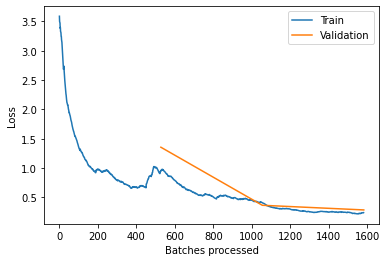

In [41]:
learn.recorder.plot_losses()


In [42]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, callbacks = [SaveModelCallback(learn, every ='improvement', monitor ='AP-helmet', name ='best_model_ft')] )

Better model found at epoch 0 with AP-helmet value: 0.6584739872132073.
Better model found at epoch 4 with AP-helmet value: 0.6800688276653641.
Better model found at epoch 5 with AP-helmet value: 0.7048843487743609.
Better model found at epoch 6 with AP-helmet value: 0.720576993360655.
Better model found at epoch 7 with AP-helmet value: 0.7378529196245637.
Better model found at epoch 8 with AP-helmet value: 0.7454951820592898.
Better model found at epoch 9 with AP-helmet value: 0.7503298600746799.


In [43]:
learn.load('best_model_ft');
learn.export('/content/gdrive/My Drive/Hard hat detection challenge/safetyHelmet_ft.pkl');

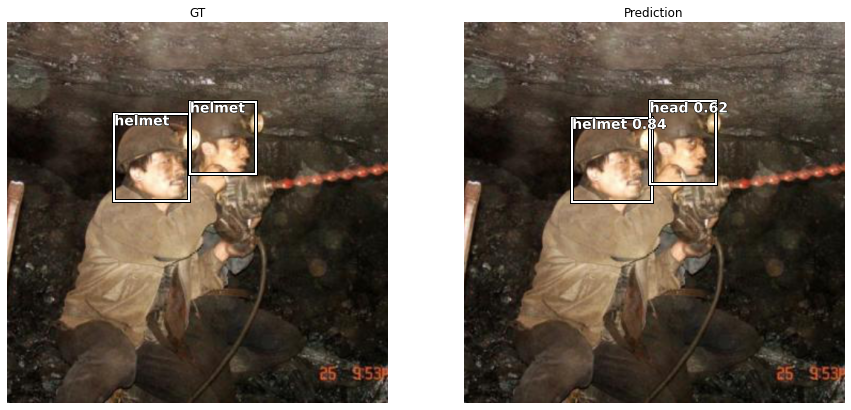

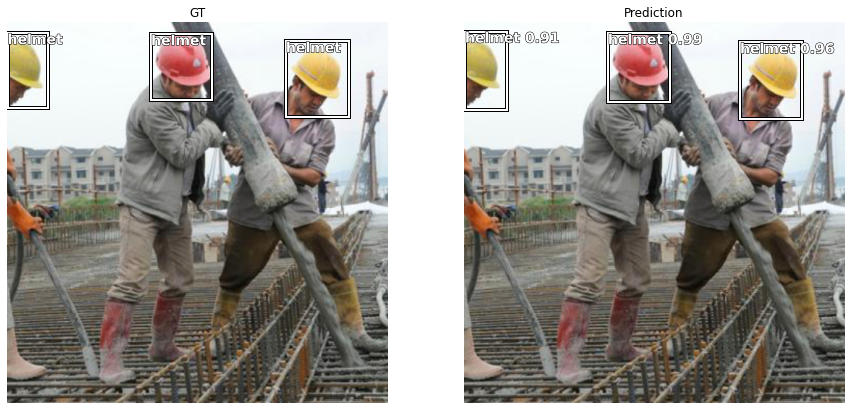

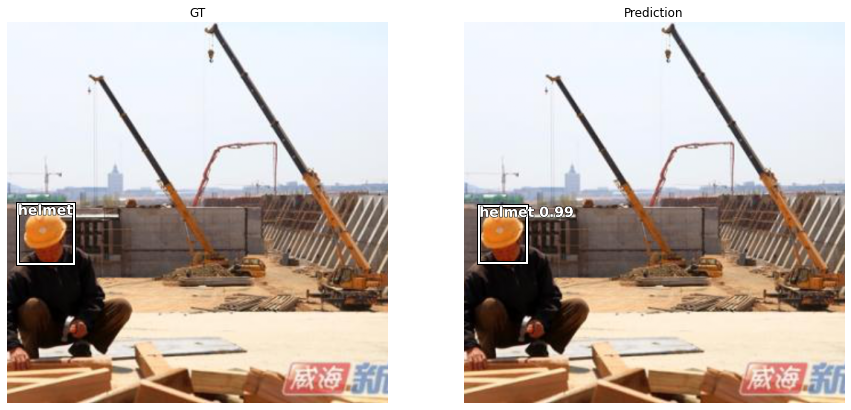

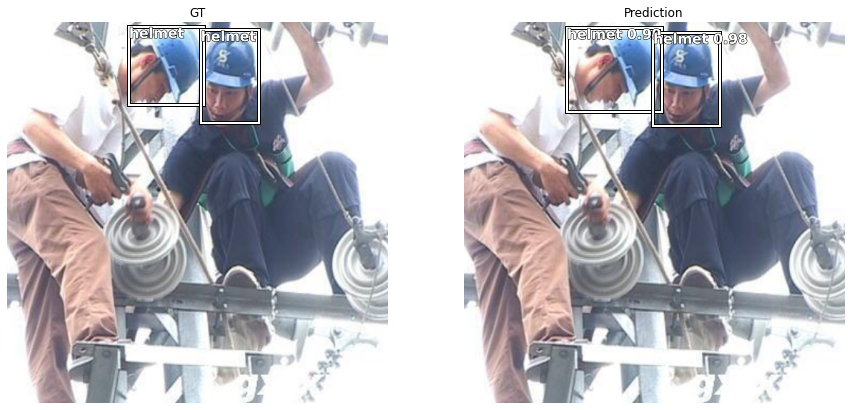

In [44]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=4)